In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [ ]:
data = pd.read_csv('../../../data/compas-scores-two-years.csv')

## Removed two duplicate coumns - 'decile_score','priors_count'
data = data.drop(['id','name','first','last','compas_screening_date',
                                  'dob','age','juv_fel_count','decile_score',
                                  'juv_misd_count','juv_other_count','days_b_screening_arrest',
                                  'c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date',
                                  'c_days_from_compas','c_charge_desc','is_recid','r_case_number','r_charge_degree',
                                  'r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in','r_jail_out',
                                  'violent_recid','is_violent_recid','vr_case_number','vr_charge_degree','vr_offense_date',
                                  'vr_charge_desc','type_of_assessment','decile_score','score_text','screening_date',
                                  'v_type_of_assessment','v_decile_score','v_score_text','v_screening_date','in_custody',
                                  'out_custody','start','end','event'],axis=1)

## Drop NULL values
data = data.dropna()

data.rename(index=str, columns={"two_year_recid": "Probability"}, inplace=True)
data['sex'] = np.where(data['sex'] == 'Female', 1, 0)
data['race'] = np.where(data['race'] != 'Caucasian', 0, 1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

protected_attribute = "race"

print(data.head(5))

# Transform data using LFR

In [9]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

protected_attribute = "sex"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2,random_state=0)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
#          k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 3.146393018263687, L_x: 0.3956168227857468,  L_y: 0.7070108302208529,  L_z: 0.048708520396299526
step: 250, loss: 1.063890753611836, L_x: 0.42759293266717036,  L_y: 0.6972125334451625,  L_z: 0.007248045816800036
step: 500, loss: 0.747268238520064, L_x: 0.42730070900732003,  L_y: 0.6976082041648337,  L_z: 0.0009077405453031429
step: 750, loss: 0.7099840341343426, L_x: 0.426852272418691,  L_y: 0.6978585355624567,  L_z: 0.0001571395169539802
step: 1000, loss: 0.7037097543001327, L_x: 0.42691004714148445,  L_y: 0.6978152655036185,  L_z: 3.2507766501987945e-05
step: 1250, loss: 0.7025353729510452, L_x: 0.42690416675252857,  L_y: 0.6978199022728939,  L_z: 8.928580212519411e-06
step: 1500, loss: 0.702120384388482, L_x: 0.4269060000395781,  L_y: 0.6978183371450911,  L_z: 6.597448599043876e-07
step: 1750, loss: 0.7021918015401428, L_x: 0.42690632217368285,  L_y: 0.6978175968648005,  L_z: 2.102829072109236e-06
step: 2000, loss: 0.7021095087297631, L_x: 0.42690691335316977,  L_y: 0

In [20]:
causal_graph = """
digraph {
sex;
age_cat;
race;
priors_count;
c_charge_degree;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
race -> Probability;
age_cat -> Probability;
race -> c_charge_degree;
sex -> c_charge_degree; c_charge_degree -> Probability;
race -> priors_count; priors_count -> Probability;
U->sex;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only


dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

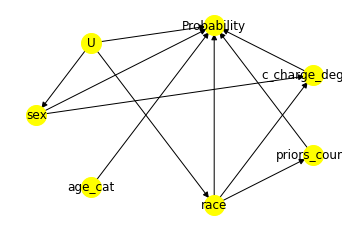

In [21]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                       
──────(Expectation(Probability|age_cat,race,priors_count))
d[sex]                                                    
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,age_cat,race,priors_count,U) = P(Probability|sex,age_cat,race,priors_count)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [23]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                       
──────(Expectation(Probability|age_cat,race,priors_count))
d[sex]                                                    
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,age_cat,race,priors_count,U) = P(Probability|sex,age_cat,race,priors_count)

## Realized estimand
b: Probability~sex+age_cat+race+priors_count
Target units: ate

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [20]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.03684782116697579
New effect:-0.03641502271922326



# Replace Treatment with Placebo

In [21]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.03684782116697579
New effect:0.00010130804186750125
p value:0.48



# Remove Random Subset of Data

In [22]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.03684782116697579
New effect:0.015263458055447604
p value:0.33999999999999997

